In [2]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

import utility_v1
import propagators_v1
import energy_landscapes_v1

import parallel_simulations_v1
import weighted_ensemble_v1
import metadynamics_v1
import multiple_walker_metadynamics_v1

import visualization_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

In [ ]:
# kT = 1
# dt = 0.01

# importlib.reload(energy_landscapes_v1)

# system1 = energy_landscapes_v1.deep_sine_well()
# system1.plot_quantity(system1.potential)
# system1.plot_quantity(system1.F)
# plt.show()



---------------------MULTIPLE WALKER METADYNAMICS---------------------
running 242 parallel multiple walker metadynamics simulations for 10000 steps each
molecular time: 10000 steps;  aggregate time: 2420000 steps
data points saved: 24200.0 at 100-step intervals
gaussians of height 0.0004132231404958678 are added every 100 steps
running segment 100 of 100

---------------------PARALLEL---------------------
running 242 parallel simulations for 10000 steps each
molecular time: 10000 steps;  aggregate time: 2420000 steps
data points saved: 24200.0 at 100-step intervals
running segment 100 of 100

---------------------WEIGHTED ENSEMBLE---------------------
running weighted ensemble with 6 walkers per bin in 202 bins for 100 WE rounds of 100 steps each
molecular time: 10000 steps;  maximum aggregate time: 12120000 steps
maximum data points saved: 121200
aggregate simulation time: 2162400 steps
aggregate number of walkers = number of data points saved = 21624.0 at 100-step intervals


/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/visualization_v1.py:26: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(le[0])


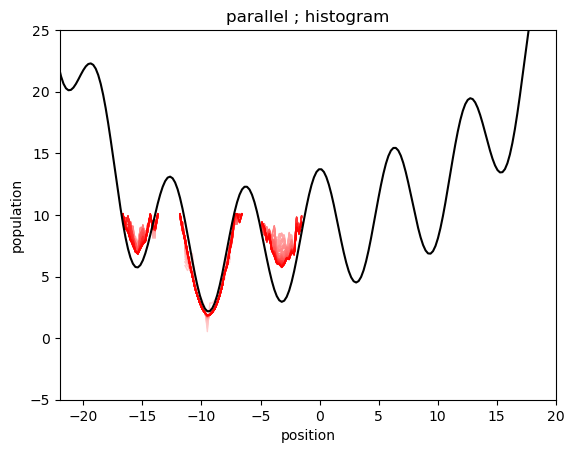

/home/jonathan/Documents/grabelab/sampling-scheme-development/sampling-methods-v3/visualization_v1.py:34: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(le[0])-true_energies


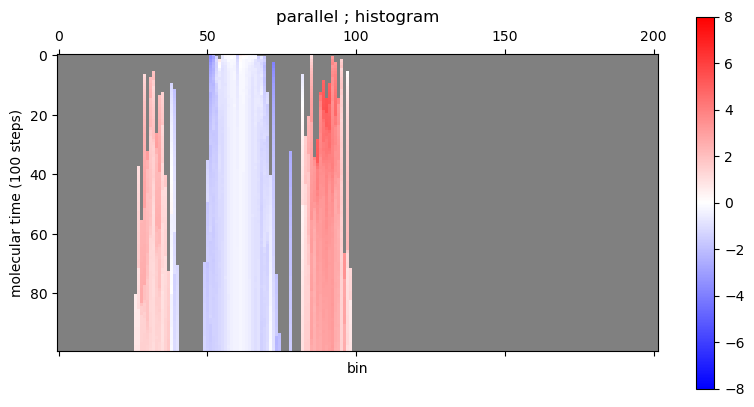

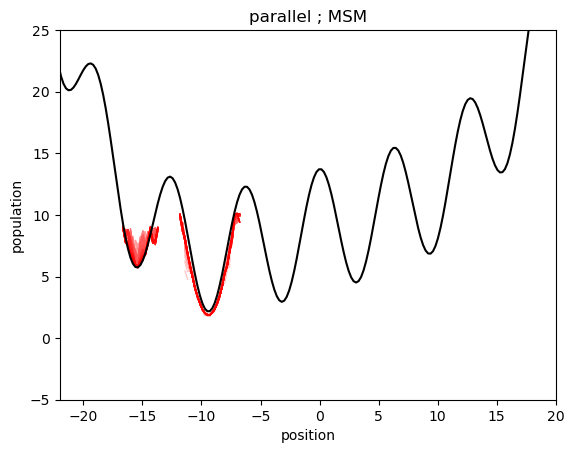

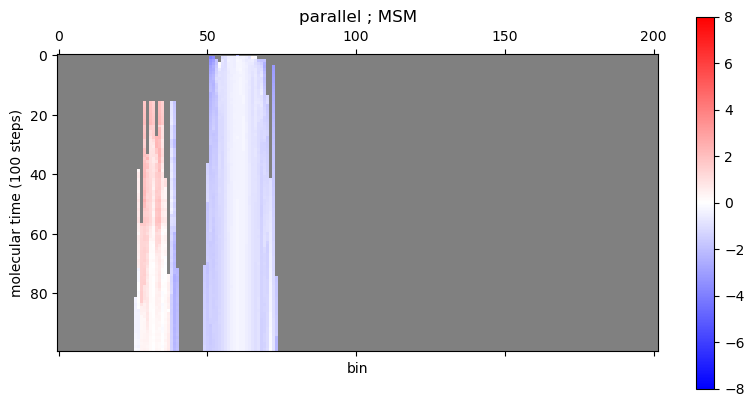

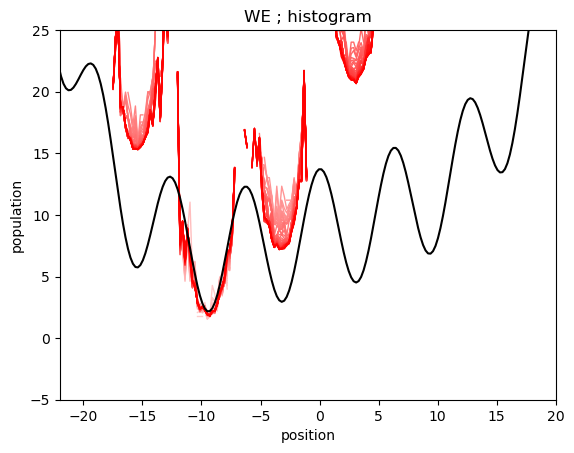

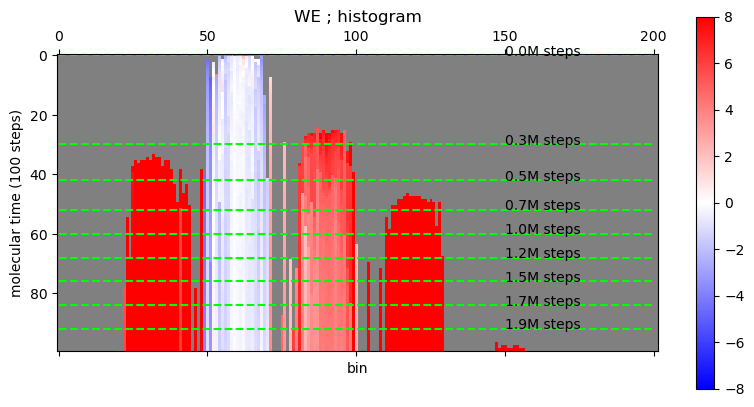

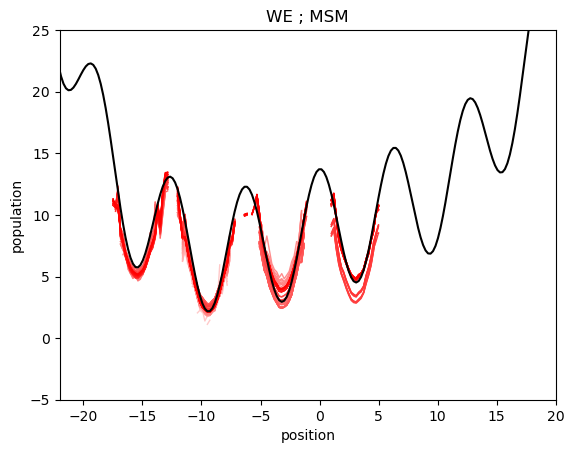

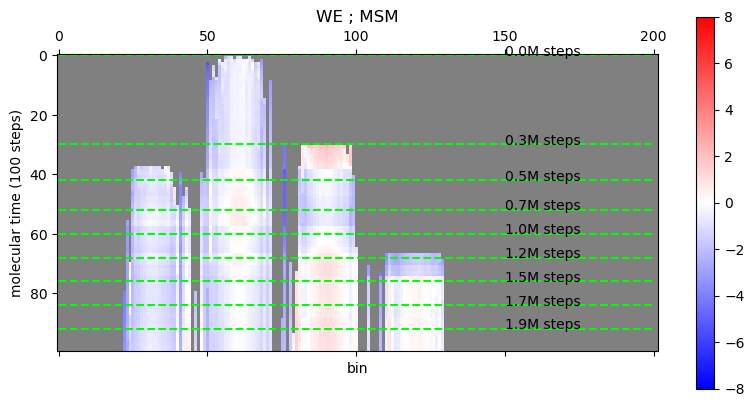

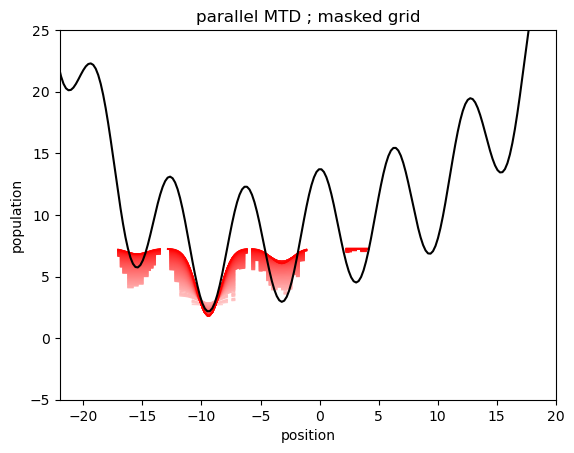

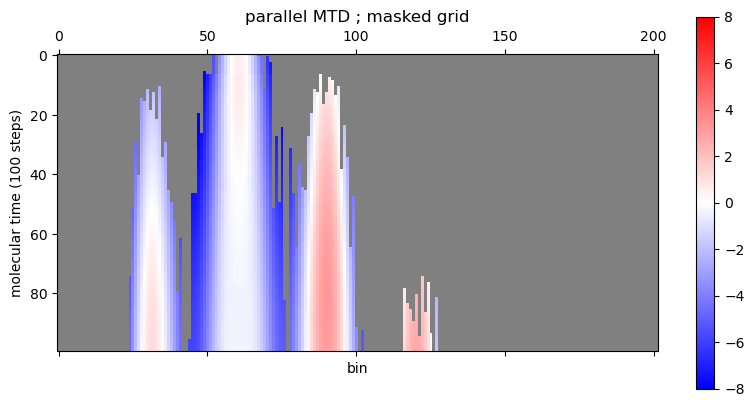

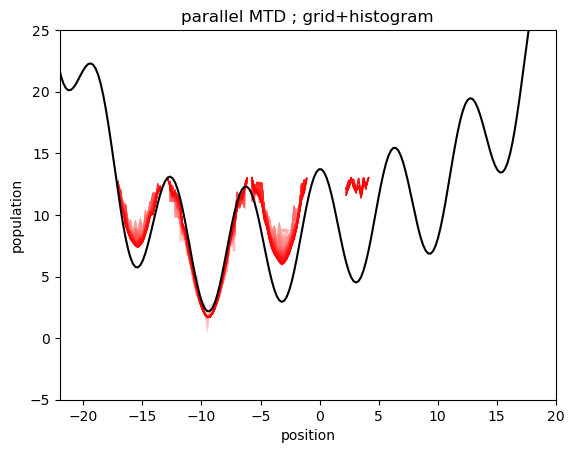

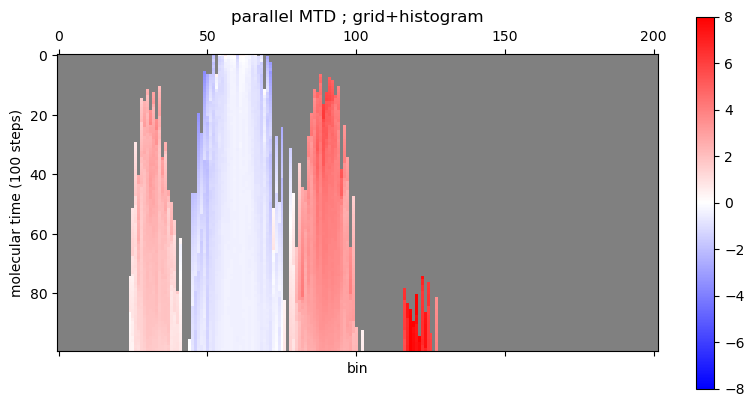

/tmp/ipykernel_149367/2972610770.py:133: RuntimeWarning: divide by zero encountered in log
  energies = -kT*np.log(lei)


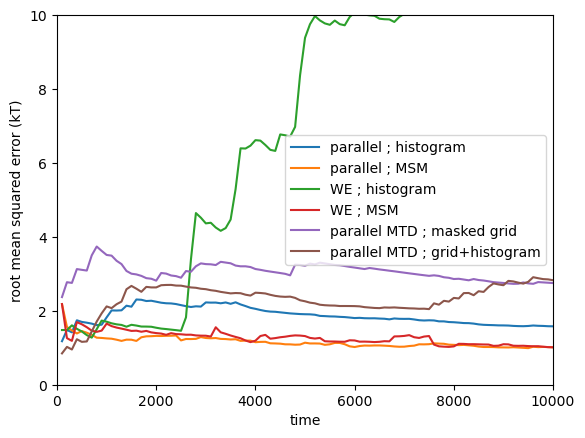

In [42]:
importlib.reload(utility_v1)
importlib.reload(propagators_v1)
importlib.reload(energy_landscapes_v1)

importlib.reload(parallel_simulations_v1)
importlib.reload(weighted_ensemble_v1)
importlib.reload(metadynamics_v1)
importlib.reload(multiple_walker_metadynamics_v1)

importlib.reload(visualization_v1)

#------------------------------system----------------------------------
system1 = energy_landscapes_v1.deep_sine_well()
# system1.plot_quantity(system1.potential)
# system1.plot_quantity(system1.F)
# plt.show()

kT = 1
dt = 0.01

#TODO make the parameters below and system (and method hyperparams) into a TEST_SETUP object so we can reproduce ones that worked well
#hyperparameters for estimating convergence
n_timepoints = 100
n_bootstrap = 3

#binning parameters
n_analysis_bins = 200
#save frequency

#simulation time limits (integration steps)
aggregate_simulation_limit = 2420000 #150000000
#frame_save_limit = 100000
molecular_time_limit = 10000 #20000
#how often the compute nodes or simulation processes can communicate
#really there should be some linear tradeoff (or tradeoff proportional to amount of data which needs to be communicated) between this and molecular_time_limit
min_communication_interval = 100 #simulation steps; current value is probably outlandishly short
#this could be made shorter but does not appear to be a limiting factor
min_frame_save_interval = min_communication_interval

#move the number of WE rounds out here; number of data points should be held constant across methods because it reflects lab storage capacity
#we_rounds_per_timepoint = 10 #convert to process communication frequency
#save_period = int(round(molecular_time_limit/(we_rounds_per_timepoint*n_timepoints))) #in steps

#define bins and calculate the true populations thereof
binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)

true_populations, true_energies = system1.normalized_pops_energies(kT, bincenters)

#run sampling methods
#TODO write bootstrapper
observables_parallel_mtd = multiple_walker_metadynamics_v1.sampler_parallel_hist_mtd(system1, aggregate_simulation_limit, molecular_time_limit, min_communication_interval, n_timepoints, kT, dt, binbounds, bincenters)
observables_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, aggregate_simulation_limit, molecular_time_limit, min_frame_save_interval, n_timepoints, kT, dt, binbounds, bincenters)
observables_we = weighted_ensemble_v1.sampler_we_hist(system1, aggregate_simulation_limit, molecular_time_limit, n_timepoints, min_communication_interval, kT, dt, binbounds)

#define which energy landscapes to plot based on the sampling methods and energy landscape estimation methods used
landscape_estimates = [[observables_parallel[0], "parallel ; histogram"], 
                       [observables_parallel[1], "parallel ; MSM"], 
                       [observables_we[0], "WE ; histogram"], 
                       [observables_we[1], "WE ; MSM"],

#                       [observables_parallel_mtd[0], "parallel MTD ; uncorrected grid"],
#                       [observables_parallel_mtd[1], "parallel MTD ; grid"],
                       [observables_parallel_mtd[4], "parallel MTD ; masked grid"],
#                       [observables_parallel_mtd[2], "parallel MTD ; histogram"],
                       [observables_parallel_mtd[3], "parallel MTD ; grid+histogram"]]
                       


#----------------------------------------------------PLOT RESULTS----------------------------------------------------
#TODO make this into its own method since this notebook cell is getting too long

landscape_estimates_plot = landscape_estimates

#landscape estimates
for le in landscape_estimates_plot:

    visualization_v1.plot_landscape_estimates(le, observables_we, bincenters, kT, true_populations, true_energies, molecular_time_limit, aggregate_simulation_limit, min_communication_interval)

#     energies = -kT*np.log(le[0])
#     #visualization_v1.plot_landscape_estimate(bincenters, le[0], true_populations, le[1], xrange = (-22,20), yrange = (0,0.4))
#     visualization_v1.plot_landscape_estimate(bincenters, energies, true_energies, le[1], xrange = (-22,20), yrange = (-5,25))


# #region explored over time
# #prints energy estimate as red for too high and blue for too low

#     energies = -kT*np.log(le[0])-true_energies

#     masked_array = np.ma.array(energies, mask=np.isnan(energies))
#     cmap = matplotlib.cm.bwr
#     cmap.set_bad('grey',1.)

#     plt.matshow(masked_array, interpolation='nearest', cmap=cmap, aspect=1, vmin=-8, vmax=8) #extent=[0,202,0,50]
#     plt.colorbar()
#     plt.title(le[1])
#     plt.xlabel("bin")
#     plt.ylabel(f"molecular time ({int(molecular_time_limit/min_communication_interval)} steps)")

#     #TODO plot aggregate time at n_aggregate_marks intervals for non-WE simulations

#     #plot aggregate time for WE simulations
#     #TODO plot these as a second graph y axis
#     if le[1][0:2] == "WE":
#         n_aggregate_marks = 10
#         for t_thresh in range(n_aggregate_marks):
#             for ti, t in enumerate(observables_we[2]):
#                 if t > aggregate_simulation_limit * t_thresh/n_aggregate_marks:
#                     plt.plot([0,200], [ti,ti], linestyle="dashed", color="lime")
#                     labelnumber = "{:.1f}".format(np.round(t/1000000, 1))
#                     plt.annotate(f"{labelnumber}M steps", (150, ti))
#                     break

#     #plt.imshow(energies)
#     #plt.axis("equal")
#     plt.show()
#     # RMS_energy_errors = []

#     # for lei in le[0]:
#     #     energies = -kT*np.log(lei)
#     #     RMS_energy_errors.append(np.sqrt(np.mean([(e-te)**2 for e, te, p in zip(energies, true_energies, lei) if p > 0])))

#     # times = [int(round((t+1)*(molecular_time_limit/n_timepoints))) for t in range(len(RMS_energy_errors))]
    
#     # plt.plot(times, RMS_energy_errors)


#convergence over time (separate loop for plotting)
for le in landscape_estimates_plot:

    RMS_energy_errors = []

    for lei in le[0]:
        energies = -kT*np.log(lei)
        RMS_energy_errors.append(np.sqrt(np.mean([(e-te)**2 for e, te, p in zip(energies, true_energies, lei) if p > 0])))

    #mean_absolute_error = [np.mean([abs(epi-pi) for pi, epi in zip(true_populations, est_pops)]) for est_pops in le[0]]
    times = [int(round((t+1)*(molecular_time_limit/n_timepoints))) for t in range(len(RMS_energy_errors))]
    
    plt.plot(times, RMS_energy_errors)


plt.legend([le[1] for le in landscape_estimates_plot])
plt.xlabel("time")
plt.ylabel("root mean squared error (kT)")

plt.xlim(0,molecular_time_limit)
plt.ylim(0,10)
#plt.ylim(0,0.1)

plt.show()

#TODO plot time of first sampling (done via imshow) and time of convergence to within 1 kT


In [ ]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()